In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
# tf.random.set_seed(RANDOM_SEED)

In [4]:
# modelPath = os.path.join(
#   'snapshots',
#   sorted(os.listdir('snapshots'), reverse=True)[0]
# )
modelPath = 'snapshots/resnet50_csv_50.h5'
modelPath 

'snapshots/resnet50_csv_50.h5'

In [5]:
# converting to inference model
model = models.load_model(modelPath, backbone_name='resnet50')
model = models.convert_model(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


/home/dl-highgpu/anaconda3/envs/models_gpu/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
model.save('finalmodel.h5')

In [6]:
classes_file = 'classes.csv'
labels_to_names = pd.read_csv(
  classes_file,
  header=None
).T.loc[0].to_dict()

In [7]:
labels_to_names

{0: 'license_plate'}

In [8]:
def predict(image):
    image = preprocess_image(image.copy())
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
    )

    boxes /= scale

    return boxes, scores, labels

In [10]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

In [16]:
def show_detected_objects(image_row):
    img_path = image_row.imagenames

    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [
    image_row.topx, image_row.topy, image_row.bottomx, image_row.bottomy
    ]
    draw_box(draw, true_box, color=(255, 255, 0))

    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [12]:
df =pd.read_csv('traindata.csv')
df['class_name'] = 'license_plate'
train_df, test_df = train_test_split(
  df,
  test_size=0.2,
  random_state=RANDOM_SEED
)

In [13]:
test_df.head()

,imagenames,topx,topy,bottomx,bottomy,class_name
115,Images/car116.jpeg,48,74,599,188,license_plate
15,Images/car16.jpeg,274,344,517,431,license_plate
211,Images/car212.jpeg,157,89,382,160,license_plate
126,Images/car127.jpeg,443,255,639,347,license_plate
6,Images/car7.jpeg,227,241,444,315,license_plate


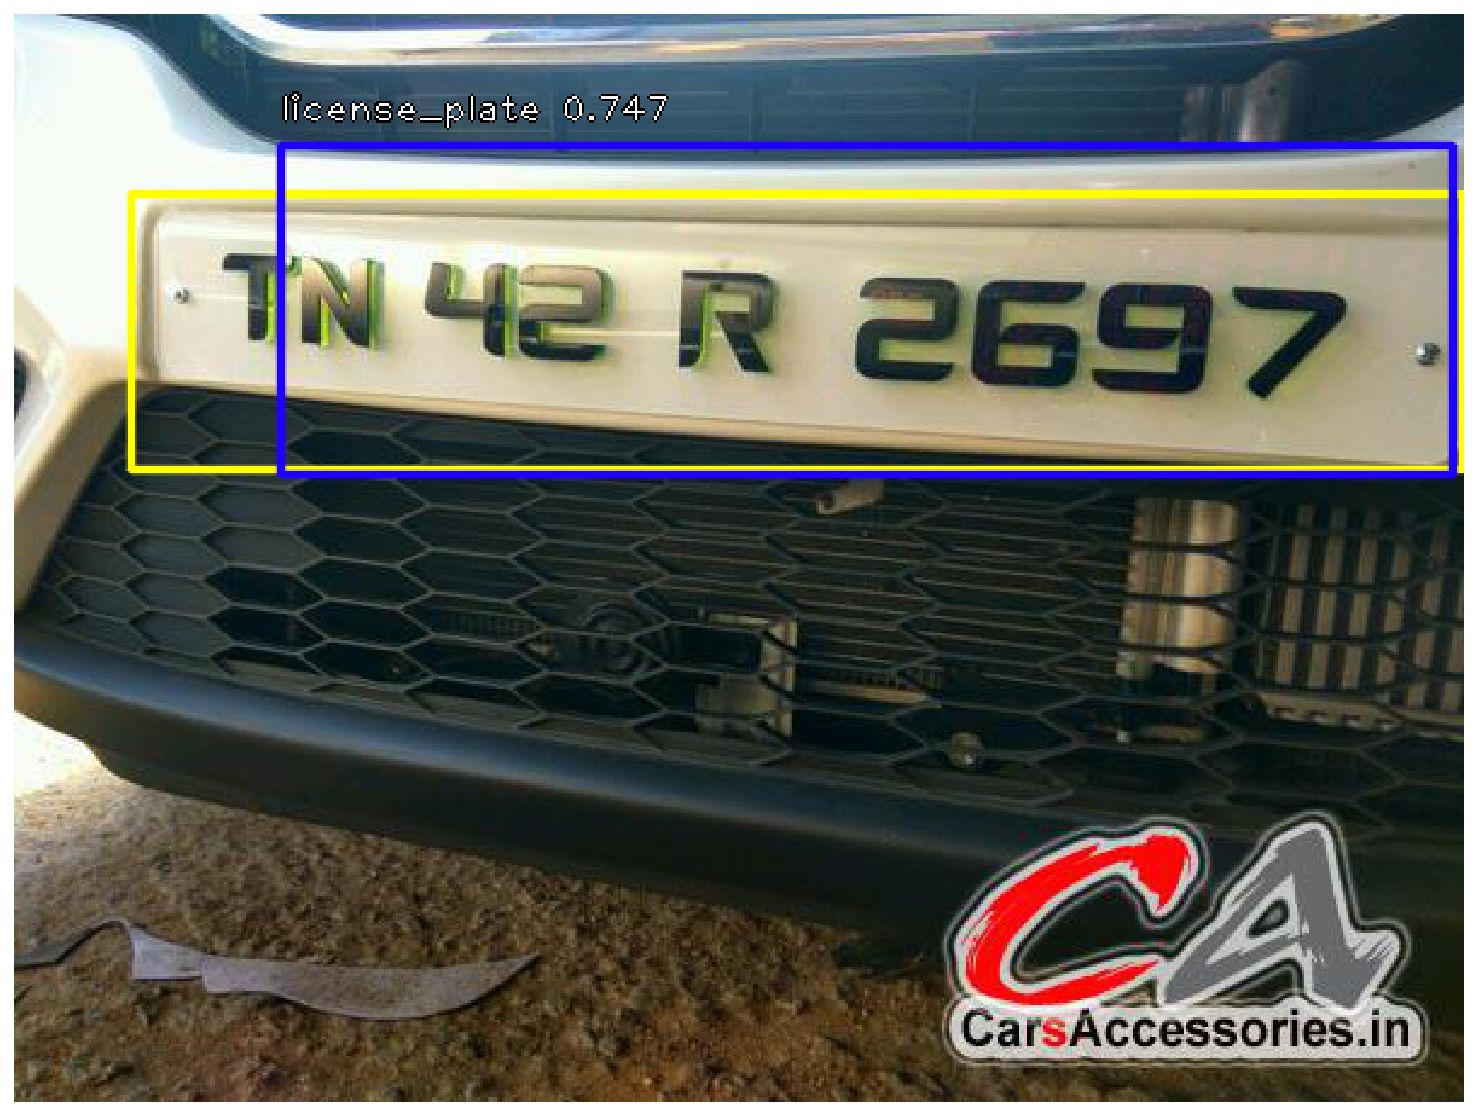

In [17]:
show_detected_objects(test_df.iloc[0])

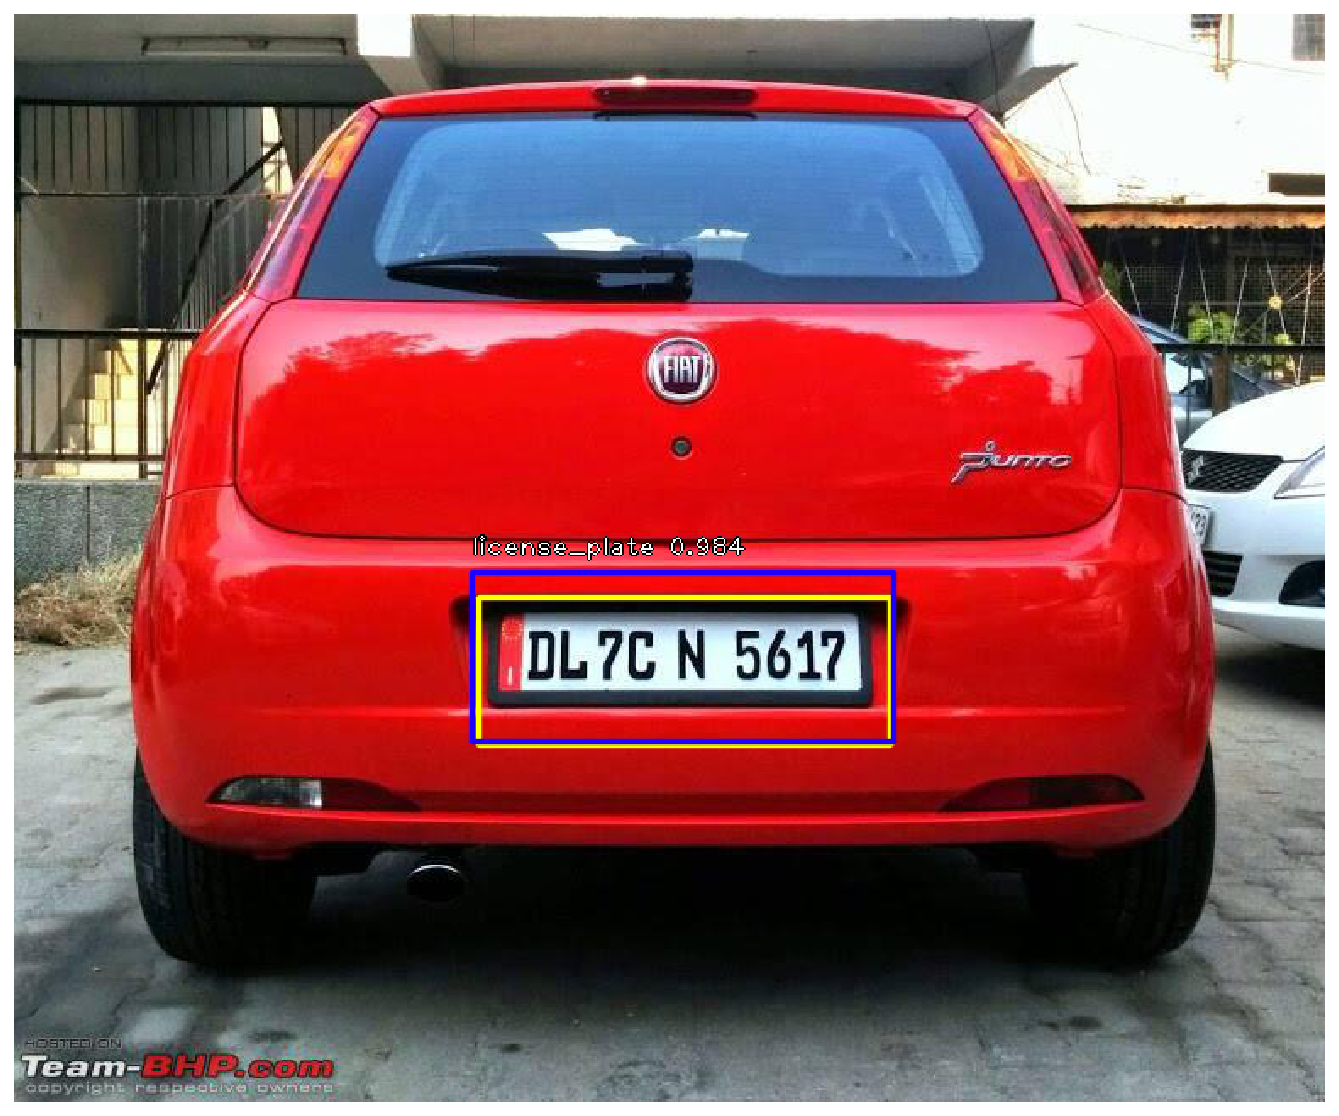

In [18]:
show_detected_objects(test_df.iloc[1])

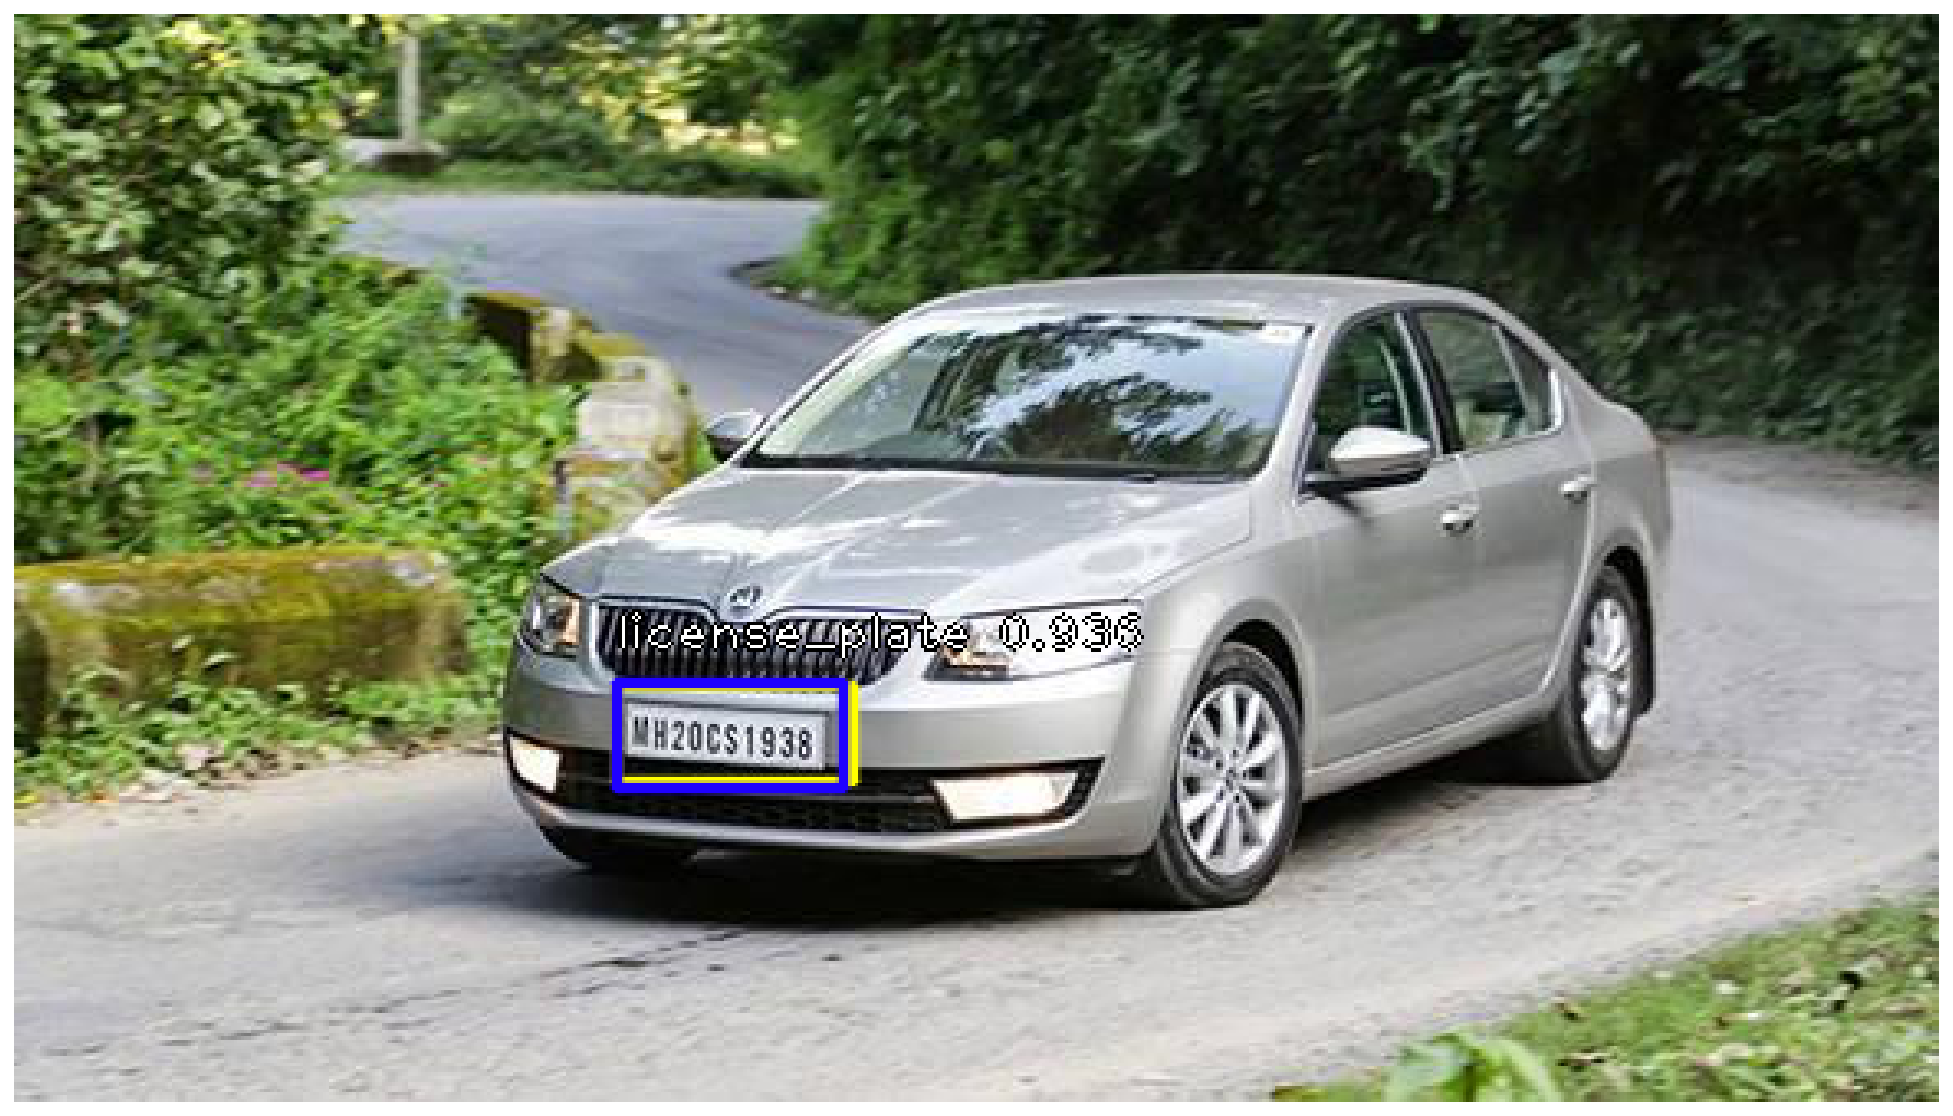

In [19]:
show_detected_objects(test_df.iloc[10])

In [23]:
# predict on a new image

def show_detected_objects_img(imgPath):
    image = read_image_bgr(imgPath)

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    

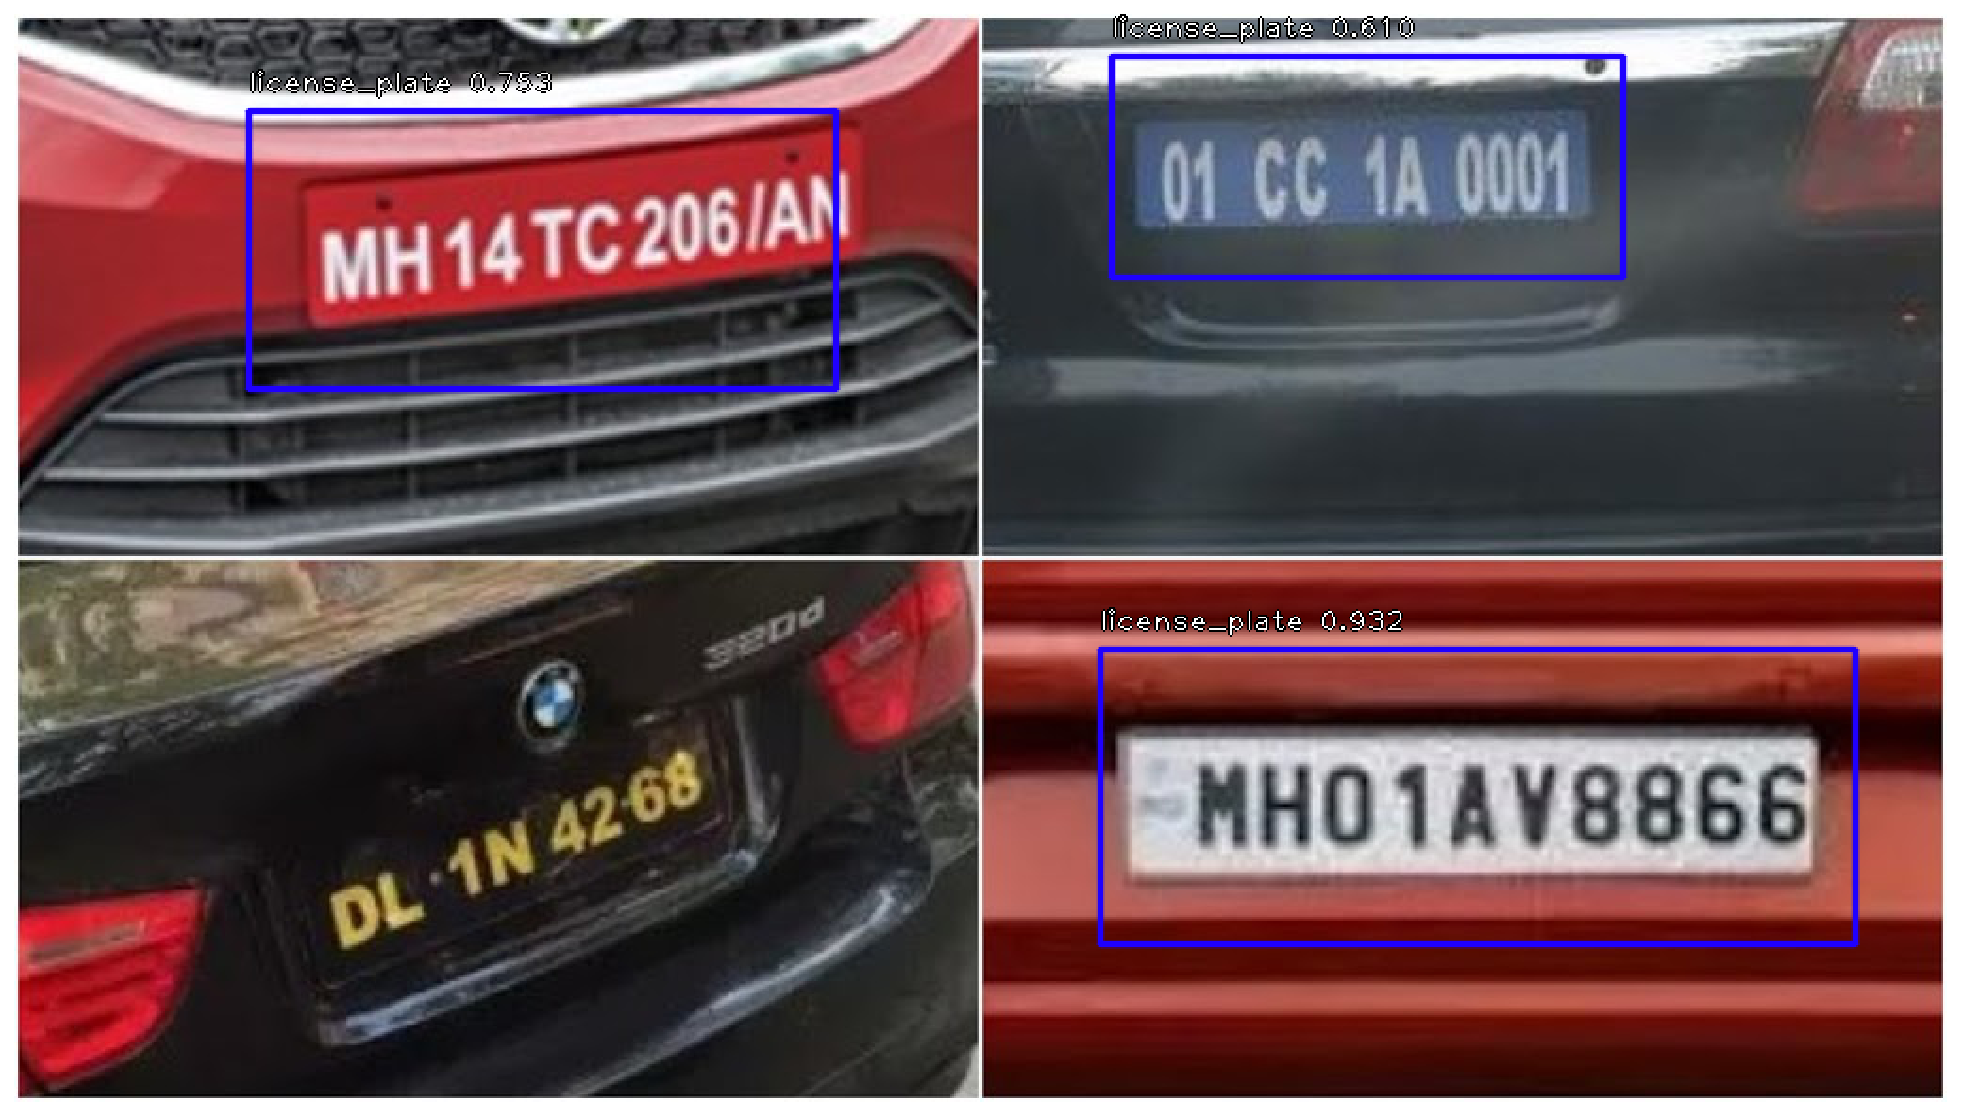

In [24]:
show_detected_objects_img('testimages/Number-2BPlate.jpg')

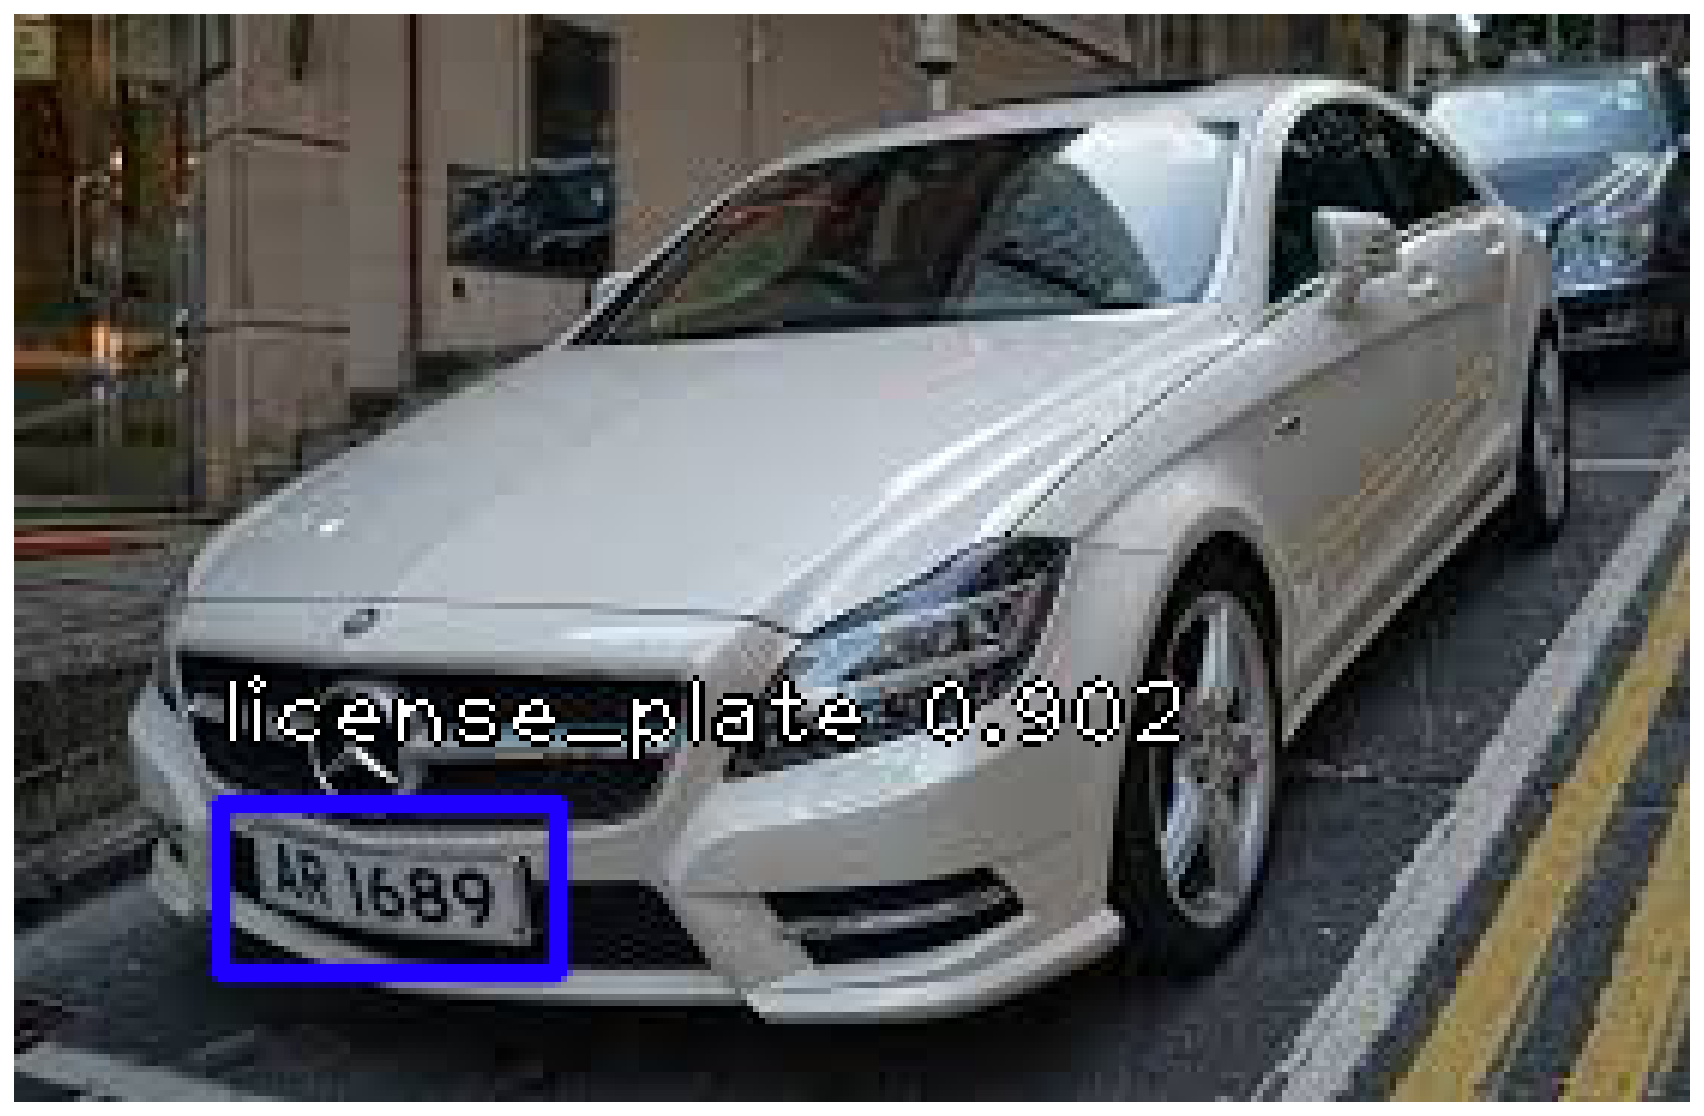

In [25]:
show_detected_objects_img('testimages/images1.jpg')